In [1]:
import matplotlib.pyplot as plt
import skimage as sk
from skimage import data, io, filters, color
from skimage.transform import rescale, resize, downscale_local_mean
import pandas as pd
import numpy as np
from math import floor

In [2970]:
img = io.imread('data/1.png')
img = color.rgb2gray(img)
img = rescale(img, 0.08, anti_aliasing=False, anti_aliasing_sigma=7)
img = ((img*2).round()/2).astype(int)

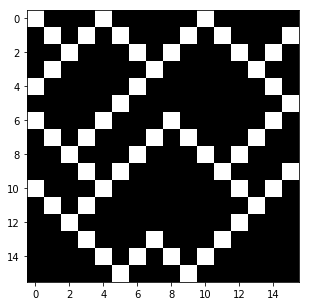

In [2971]:
plt.figure( figsize=(5,5))
plt.imshow(img, cmap='gray',)

In [2081]:
img = io.imread('data/4.png')
img = color.rgb2gray(img)
img = rescale(img, 0.08, anti_aliasing=False, anti_aliasing_sigma=7)
img = ((img).round()).astype(int)

In [2776]:
img = io.imread('data/6.png')
img = color.rgb2gray(img)
img = rescale(img, 1/12, anti_aliasing=False, anti_aliasing_sigma=7)
img = ((img*2).round()/2).astype(int)

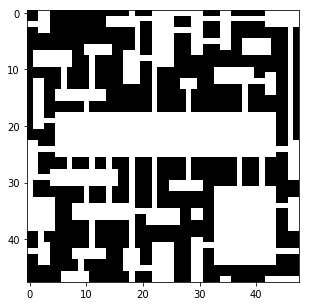

In [2777]:
plt.figure( figsize=(5,5))
plt.imshow(img, cmap='gray',)

In [2972]:
def preprocess_blocks(img, kernel_size):
    
#     blocks_count = dict()
    
#     for i in range(0, img.shape[0], kernel_size):
#         for j in range(0, img.shape[0], kernel_size):
#             block = tuple(img[i:i+kernel_size, j:j+kernel_size].flatten())
#             if block not in blocks_dict:
#                 blocks_dict[block] = 1
#                 #blocks_dict[block] = num_blocks
#             else:
#                 blocks_dict[block] += 1
        
#     blocks_count.values
    
#     blocks_id = dict()
#     num_blocks = 0
#     for (block, count) in blocks_count.items():
#         blocks_id[block] 
#         num_blocks+=1
                
                
    return blocks_dict

In [2973]:
blocks = preprocess_blocks(img, 3)

NameError: name 'blocks_dict' is not defined

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

In [2969]:
np.sort(np.array(list(blocks.values())))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57])

In [2962]:
pd.DataFrame().from_dict(blocks, orient='index').reset_index().reset_index()

,level_0,index,0
0,0,"(0, 0, 1, 0, 0, 1, 1, 1, 1)",0
1,1,"(1, 0, 0, 1, 0, 0, 1, 0, 0)",1
2,2,"(0, 0, 0, 0, 0, 0, 0, 0, 0)",2
3,3,"(0, 0, 0, 0, 0, 1, 0, 0, 1)",3
4,4,"(0, 0, 0, 1, 1, 1, 1, 1, 1)",4
5,5,"(1, 0, 0, 1, 1, 1, 1, 1, 0)",5
6,6,"(0, 1, 1, 1, 1, 1, 0, 1, 1)",6
7,7,"(1, 1, 1, 1, 1, 0, 1, 1, 0)",7
8,8,"(1, 1, 1, 0, 0, 1, 0, 0, 1)",8
9,9,"(1, 0, 0, 1, 1, 1, 1, 0, 0)",9


In [1874]:
img = io.imread('data/pebbles.jpg')
img = color.rgb2gray(img)
img = rescale(img, 1/20, anti_aliasing=True, anti_aliasing_sigma=1.5)
img = (np.round(img*5)).astype(int)
img = img[:120, :120]

In [2712]:
img = io.imread('data/aztec.png')
img = color.rgb2gray(img)
#img = rescale(img, 1/6, anti_aliasing=False, anti_aliasing_sigma=1.5)
img = rescale(img, 1/12, anti_aliasing=False, anti_aliasing_sigma=1.5)

In [2713]:
img

array([[0.99313725, 0.99803922, 0.99803922, ..., 0.99803922, 0.99803922,
        0.99803922],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.00588235, 0.00392157, 0.00392157, ..., 0.00392157, 0.00392157,
        0.00392157],
       ...,
       [0.30294118, 0.30980392, 0.30980392, ..., 0.2754902 , 0.27843137,
        0.27843137],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.99607843, 0.99607843, ..., 0.99607843, 0.99607843,
        0.99607843]])

In [2714]:
img = (np.round(img)).astype(int)
img = img[1:109,1:109]

In [2715]:
img

/Users/milesturpin/miniconda3/lib/python3.6/site-packages/IPython/core/displayhook.py:271: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  'Flushing oldest {cull_count} entries.'.format(sz=sz, cull_count=cull_count))


array([[1, 1, 1, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 1],
       ...,
       [1, 1, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [2716]:
img.shape

(108, 108)

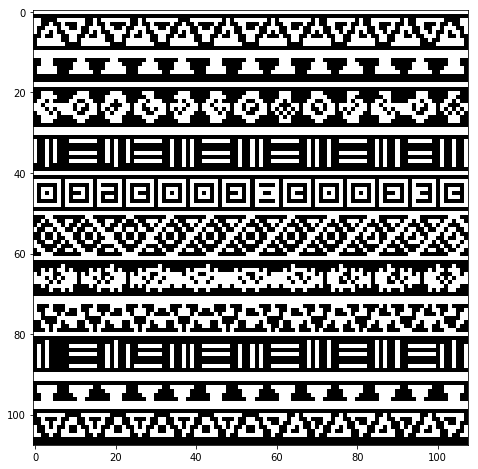

In [2717]:
plt.figure( figsize=(8,8))
plt.imshow(img, cmap='gray',)

In [2637]:
img = io.imread('data/maze.png')
img = color.rgb2gray(img)
img = rescale(img, 1/27, anti_aliasing=False, anti_aliasing_sigma=1.5)
img = (np.round(img)).astype(int)
img = img[:64, :120]

In [2638]:
img.shape

(64, 80)

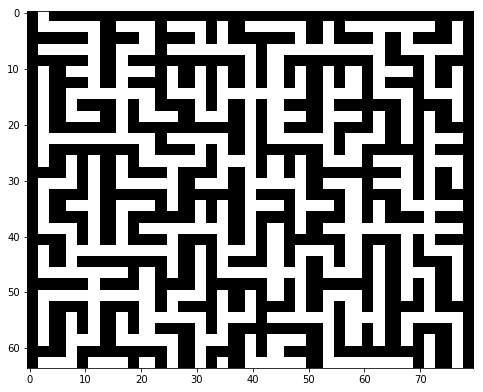

In [2639]:
plt.figure( figsize=(8,8))
plt.imshow(img, cmap='gray',)

Take a 3x3 patch and turn into sequence, treat each entry as categorical variance and compute covariance matrix between each pair

In [4]:
def ndim2flat_idx(idx, shape):
    """
    Inverse to np.unravel_index.
    
    E.g. ndim2flat_idx([1,2], (3,3)) = 5
    """
    flat_idx = 0
    place = 1
    for i in range(len(idx))[::-1]:
        if idx[i] >= shape[i]:
            raise ValueError('Index too big for shape!')
        flat_idx += idx[i]*place
        place = place*shape[i]
    return flat_idx

oh wait Im counting if matches self oops

In [1651]:
# num loops = 64*64*50*50 = 10 million

def compute_count_tensor(img, kernel_size, stride, dilation=0):
    """
    Currently kernel size is also stride.
    """
    
    indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    
    w = img.shape[1]
    h = img.shape[0]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((w-kernel_size)/stride)+1
    
    count_tensor = np.zeros([kernel_size**2, kernel_size**2, 
                             np.max(img)-np.min(img)+1, np.max(img)-np.min(img)+1])
    print(count_tensor.shape)
    for i in range(0, num_convs_h, stride):
        for j in range(0, num_convs_w, stride):
            for idx1 in indices:
                for idx2 in indices:

                    idx = (
                        ndim2flat_idx(idx1, (kernel_size,kernel_size)),
                        ndim2flat_idx(idx2, (kernel_size,kernel_size)),
                        img[i + idx1[0], j + idx1[1]],
                        img[i + idx2[0], j + idx2[1]]
                    )

                    if idx1 != idx2:
                        count_tensor[idx] = count_tensor[idx] + 1
                        
    return count_tensor

def normalize_count_tensor(count_tensor):
    normalized_tensor = count_tensor / np.sum(count_tensor, axis=(2,3), keepdims=True)
    affinity_tensor = np.log(normalized_tensor + 0.0000001)
    affinity_tensor = np.nan_to_num(affinity_tensor, nan=0)
    return affinity_tensor

In [2778]:
img.shape

(48, 48)

In [2904]:
kernel_size = 16
learn_stride=2
stride = 8
num_colors = np.max(img) - np.min(img) + 1
count_tensor = compute_count_tensor(img, kernel_size=kernel_size, stride=learn_stride)
affinity_tensor = normalize_count_tensor(count_tensor)

(256, 256, 2, 2)


/Users/milesturpin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


In [2905]:
np.swapaxes(np.swapaxes(count_tensor, 0,2), 1,3).round(2)

array([[[[ 0., 49., 45., ..., 26., 15., 28.],
         [49.,  0., 49., ..., 25., 18., 27.],
         [45., 49.,  0., ..., 25., 19., 26.],
         ...,
         [26., 25., 25., ...,  0., 25., 38.],
         [15., 18., 19., ..., 25.,  0., 26.],
         [28., 27., 26., ..., 38., 26.,  0.]],

        [[ 0., 11., 15., ..., 34., 45., 32.],
         [ 7.,  0.,  7., ..., 31., 38., 29.],
         [11.,  7.,  0., ..., 31., 37., 30.],
         ...,
         [13., 14., 14., ...,  0., 14.,  1.],
         [12.,  9.,  8., ...,  2.,  0.,  1.],
         [13., 14., 15., ...,  3., 15.,  0.]]],


       [[[ 0.,  7., 11., ..., 13., 12., 13.],
         [11.,  0.,  7., ..., 14.,  9., 14.],
         [15.,  7.,  0., ..., 14.,  8., 15.],
         ...,
         [34., 31., 31., ...,  0.,  2.,  3.],
         [45., 38., 37., ..., 14.,  0., 15.],
         [32., 29., 30., ...,  1.,  1.,  0.]],

        [[ 0., 14., 10., ...,  8.,  9.,  8.],
         [14.,  0., 18., ..., 11., 16., 11.],
         [10., 18.,  0., ..., 

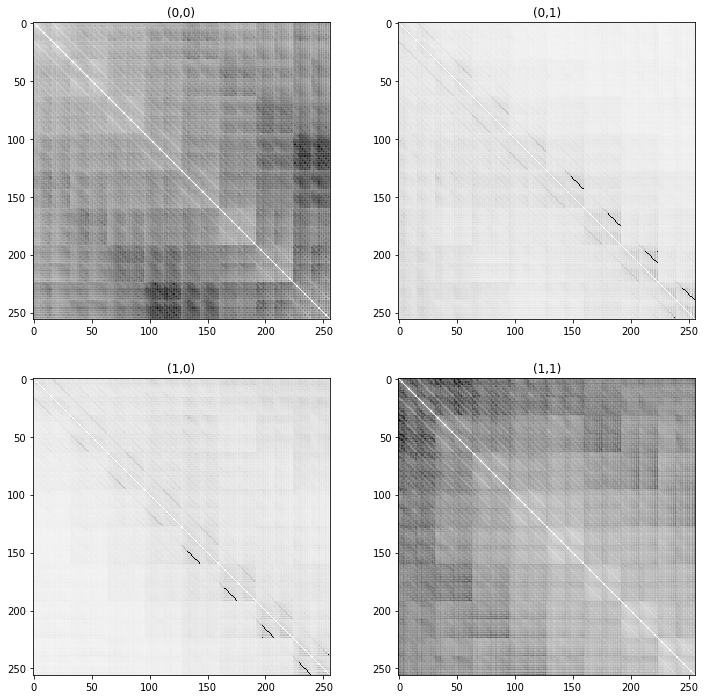

In [2906]:
fig, axes = plt.subplots(2,2, figsize=(12,12))
for i in range(2):
    for j in range(2):
        axes[i,j].imshow(affinity_tensor[:,:,i,j], cmap='gray')
        axes[i,j].set_title(f'({i},{j})')

In [2059]:
# def calc_total_log_prob(affinity_tensor, img, kernel_size, stride):
    
#     w = img.shape[1]
#     h = img.shape[0]
#     num_convs_w = floor((w-kernel_size)/stride)+1
#     num_convs_h = floor((w-kernel_size)/stride)+1
    
#     log_prob = 0
#     cnt2 = 0
#     for i in stride * np.arange(num_convs_h):
#         #print('i', i)
#         for j in stride * np.arange(num_convs_w):
#             #print('j', j)
#             local_prob, cnt = calc_log_prob(affinity_tensor, img, i, j, kernel_size)
#             log_prob = log_prob + local_prob
#             #print(cnt)
#             cnt2 += cnt
                    
#     return log_prob, cnt2

# def calc_log_prob(affinity_tensor, img, i, j, kernel_size):
    
#     indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
#     log_prob = 0
#     #res = []
#     #res2 = []
#     cnt = 0
#     for pos1 in range(16):
#         # plus 1 so that no collisions
#         for pos2 in range(pos1+1, 16):
#             idx1 = indices[pos1]
#             idx2 = indices[pos2]
#             #print(idx1, idx2)

#             idx = (
#                 pos1, 
#                 pos2,
#                 img[i + idx1[0], j + idx1[1]],
#                 img[i + idx2[0], j + idx2[1]]
#             )
            
#             if idx1 != idx2:
#                 #res.append(int(affinity_tensor[idx]))
#                 #res2.append({(i,j, ndim2flat_idx(idx1, (kernel_size,kernel_size)),
#                 #   ndim2flat_idx(idx2, (kernel_size,kernel_size))) :int(affinity_tensor[idx])})
#                 log_prob = log_prob + affinity_tensor[idx]
#                 cnt+=1
                    
#     return log_prob, cnt
# #, res, res2

In [2486]:
def construct_filters_idx_dict(shape, kernel_size, stride):
    """
    Creates a dict that gives all the absolute sequence image indexes in each filter
    E.g.
    (0, 2) -> [2, 3, 8, 9 ...]
    
    """
    
    image_idx = np.arange(shape[0]*shape[1]).reshape(shape)
    
    num_convs_h = floor((shape[0]-kernel_size)/stride)+1
    num_convs_w = floor((shape[1]-kernel_size)/stride)+1
    
    total = dict()
    
    log_prob = 0
    cnt2 = 0
    for i in stride * np.arange(num_convs_h):
        for j in stride * np.arange(num_convs_w):
            
            sub_img = image_idx[i:i+kernel_size, j:j+kernel_size].flatten().tolist()
            total[(i,j)] = sub_img
    return total

def invert_dict(d): 
    inverse = dict() 
    for key in d: 
        # Go through the list that is saved in the dict:
        for item in d[key]:
            # Check if in the inverted dict the key exists
            if item not in inverse: 
                # If not create a new list
                inverse[item] = [key] 
            else: 
                inverse[item].append(key) 
    return inverse

def invert_filter2img_dict(filter_idx_to_image_idx, kernel_size, shape): 
    """
    output_dict behavior: 35 -> [(0, 2, 9), (2, 2, 7) … ] 
    """
    
    image_idx_to_filter_idx = dict() 
    for (i,j), img_idxs in filter_idx_to_image_idx.items(): 
        # Go through the list that is saved in the dict:
        for img_idx in img_idxs:
            # Check if in the inverted dict the key exists
            if img_idx not in image_idx_to_filter_idx: 
                # If not create a new list
                # (kernel idx0, kernel idx1, relative position in kernel)
                ker_seq_pos = get_seq_pos(i,j,kernel_size, shape, img_idx)
                image_idx_to_filter_idx[img_idx] = [(i, j, ker_seq_pos)] 
            else: 
                ker_seq_pos = get_seq_pos(i,j,kernel_size, shape, img_idx)
                image_idx_to_filter_idx[img_idx].append((i, j, ker_seq_pos))
    image_idx_to_filter_idx = {
        key:np.array(val) for key, val in image_idx_to_filter_idx.items()
    }
    return image_idx_to_filter_idx

def construct_alternate_img_array(image_idx_to_filter_idx, img, kernel_size, stride):
    """
    Construct another way to index into image values
    (i, j, rel_ker_pos, image value)
    Makes it easy to 
    
    Just need to keep updated similarly to image. There are dependencies here.
    """
    
    
    arr = np.zeros((
        num_convs(img.shape[0], kernel_size, stride),
        num_convs(img.shape[1], kernel_size, stride),
        kernel_size**2))
    
    for abs_seq_idx, pos_info in image_idx_to_filter_idx.items(): 
        # Go through the list that is saved in the dict:
        for (i, j, rel_pos) in pos_info:
            img_idx = np.unravel_index(abs_seq_idx, img.shape)
            arr[int(i/stride), int(j/stride), rel_pos] = img[img_idx]
    
#     alt_img = alt_img.reshape((
#         num_convs(img.shape[0], kernel_size, stride), 
#         num_convs(img.shape[1], kernel_size, stride), 
#         kernel_size**2,
#         -1
#     ))
    
    #alt_img = np.swapaxes(alt_img, 0, 1)
    
    return arr

# def augment_img2filter_dict(d):
    
#     for image_idx, filter_list in image_idx_to_filter_idx.items():
#         for i,j in filter_list:
#             (i,j, )

In [2467]:
filter_idx_to_image_idx = construct_filters_idx_dict((3,3), 2, 1)
#image_idx_to_filter_idx = invert_dict(filter_idx_to_image_idx)
image_idx_to_filter_idx = invert_filter2img_dict(filter_idx_to_image_idx, 2, (3,3))
alt_img = construct_alternate_img_array(
    image_idx_to_filter_idx, np.arange(9).reshape((3,3), order='C'), 2, 1)

In [2468]:
alt_img.shape

(2, 2, 4)

In [2469]:
np.arange(9).reshape((3,3))

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [2470]:
alt_img

array([[[0., 1., 3., 4.],
        [1., 2., 4., 5.]],

       [[3., 4., 6., 7.],
        [4., 5., 7., 8.]]])

In [2472]:
alt_img[0,0,:]

array([0., 1., 3., 4.])

In [2337]:
num_convs = lambda dim_len, kernel_size, stride: floor((dim_len-kernel_size)/stride)+1

In [2331]:
alt_img[image_idx_to_filter_idx[34], 4]

array([[ 0, 33,  1],
       [ 0, 34,  0]])

In [2336]:
alt_img[:10]

array([[0, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 0, 0],
       [0, 0, 2, 1],
       [1, 0, 0, 1],
       [0, 0, 3, 0],
       [0, 1, 2, 0],
       [1, 0, 1, 0],
       [1, 1, 0, 0],
       [0, 1, 1, 0]])

In [2383]:
alt_img.shape

(13, 13, 81, 4)

In [2388]:
alt_img[0,3,3]

array([ 3,  0, 42,  0])

In [2381]:
image_idx_to_filter_idx[34]

array([[ 0, 27,  7],
       [ 0, 30,  4],
       [ 0, 33,  1]])

In [2385]:
stride

3

In [2387]:
alt_img[
    (image_idx_to_filter_idx[34][:,0]/stride).astype(int),
    (image_idx_to_filter_idx[34][:,1]/stride).astype(int),
    image_idx_to_filter_idx[34][:,2],
    :
]

array([[ 6, 12,  3,  0],
       [ 0, 15,  4,  1],
       [ 0, 15, 57,  1]])

In [2328]:
alt_img.shape

(44100, 4)

In [2318]:
image_idx_to_filter_idx[1000]

array([[ 8, 45,  3],
       [ 8, 46,  2],
       [ 9, 45,  1],
       [ 9, 46,  0]])

In [2303]:
img.shape

(106, 106)

In [749]:
set(image_idx_to_filter_idx[34])

{(0, 0), (0, 2), (2, 0), (2, 2)}

In [794]:
def get_seq_pos(i, j, kernel_size, shape, abs_seq_pos):
    abs_idx = np.unravel_index(abs_seq_pos, shape)
    ker_pos = abs_idx - np.array([i,j])
    seq_pos = ker_pos[0]*kernel_size + ker_pos[1]
    return seq_pos

In [795]:
get_seq_pos(0,2, 4, (16,16), 34)

8

In [688]:
#def kernel2absolute_seq_pos()

# def construct_unique_pairs(shape, kernel_size, stride):
    
#     image_idx = np.arange(shape[0]*shape[1]).reshape(shape)
#     # Goes in order across rows e.g. (0,0) (0,1) etc.
#     indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    
#     num_convs_h = floor((shape[0]-kernel_size)/stride)+1
#     num_convs_w = floor((shape[1]-kernel_size)/stride)+1
    
#     seq_pairs = []
#     idx_pairs = []
#     for i in stride * np.arange(num_convs_h):
#         for j in stride * np.arange(num_convs_w):
#             for kernel_seq_pos1 in range(kernel_size**2):
#                 # plus 1 so that no collisions
#                 for kernel_seq_pos2 in range(kernel_seq_pos1+1, kernel_size**2):
                    
#                     # Convert position along sequence to absolute index
#                     # 3 -> [0, 2] -> [4,4]+[0,2]=[4,6] -> 70
#                     kernel_idx1 = indices[kernel_seq_pos1]
#                     kernel_idx2 = indices[kernel_seq_pos2]
#                     abs_idx1 = (i + kernel_idx1[0], j + kernel_idx1[1])
#                     abs_idx2 = (i + kernel_idx2[0], j + kernel_idx2[1])
#                     abs_seq_pos1 = image_idx[abs_idx1]
#                     abs_seq_pos2 = image_idx[abs_idx2]
                    
                    
#                     seq_pairs.append((abs_seq_pos1, abs_seq_pos2))
#                     idx_pairs.append((abs_idx1, abs_idx2))
#                     #print(i,j,kernel_seq_pos1, abs_seq_pos1)
                    
#     # Remove duplicates with set
#     print(len(seq_pairs), '->', len(list(set(seq_pairs))))
#     return list(set(seq_pairs)), list(set(idx_pairs))

In [752]:
#def kernel2absolute_seq_pos()

def construct_pairs(img, kernel_size, stride):
    
    image_idx = np.arange(img.shape[0]*img.shape[1]).reshape(img.shape)
    # Goes in order across rows e.g. (0,0) (0,1) etc.
    indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    
    num_convs_h = floor((img.shape[0]-kernel_size)/stride)+1
    num_convs_w = floor((img.shape[1]-kernel_size)/stride)+1
    
    seq_pairs = []
    idx_pairs = []
    affinity_idx_pairs = []
    for i in stride * np.arange(num_convs_h):
        for j in stride * np.arange(num_convs_w):
            for kernel_seq_pos1 in range(kernel_size**2):
                # plus 1 so that no collisions
                for kernel_seq_pos2 in range(kernel_seq_pos1+1, kernel_size**2):
                    
                    # Convert position along sequence to absolute index
                    # 3 -> [0, 2] -> [4,4]+[0,2]=[4,6] -> 70
                    kernel_idx1 = indices[kernel_seq_pos1]
                    kernel_idx2 = indices[kernel_seq_pos2]
                    abs_idx1 = (i + kernel_idx1[0], j + kernel_idx1[1])
                    abs_idx2 = (i + kernel_idx2[0], j + kernel_idx2[1])
                    abs_seq_pos1 = image_idx[abs_idx1]
                    abs_seq_pos2 = image_idx[abs_idx2]
                    
                    
                    seq_pairs.append((abs_seq_pos1, abs_seq_pos2))
                    idx_pairs.append((abs_idx1, abs_idx2))
                    #print(i,j,kernel_seq_pos1, abs_seq_pos1)
                    
                    affinity_idx_pairs.append([
                        kernel_seq_pos1,
                        kernel_seq_pos2,
                        img[abs_idx1],
                        img[abs_idx2]
                    ])
                        

    #return list(set(seq_pairs)), list(set(idx_pairs))
    return affinity_idx_pairs

In [753]:
#aip = construct_pairs(img, 4, 2)

In [754]:
aip

[[0, 1, 1, 0],
 [0, 2, 1, 0],
 [0, 3, 1, 0],
 [0, 4, 1, 0],
 [0, 5, 1, 1],
 [0, 6, 1, 0],
 [0, 7, 1, 1],
 [0, 8, 1, 0],
 [0, 9, 1, 0],
 [0, 10, 1, 1],
 [0, 11, 1, 0],
 [0, 12, 1, 0],
 [0, 13, 1, 1],
 [0, 14, 1, 0],
 [0, 15, 1, 0],
 [1, 2, 0, 0],
 [1, 3, 0, 0],
 [1, 4, 0, 0],
 [1, 5, 0, 1],
 [1, 6, 0, 0],
 [1, 7, 0, 1],
 [1, 8, 0, 0],
 [1, 9, 0, 0],
 [1, 10, 0, 1],
 [1, 11, 0, 0],
 [1, 12, 0, 0],
 [1, 13, 0, 1],
 [1, 14, 0, 0],
 [1, 15, 0, 0],
 [2, 3, 0, 0],
 [2, 4, 0, 0],
 [2, 5, 0, 1],
 [2, 6, 0, 0],
 [2, 7, 0, 1],
 [2, 8, 0, 0],
 [2, 9, 0, 0],
 [2, 10, 0, 1],
 [2, 11, 0, 0],
 [2, 12, 0, 0],
 [2, 13, 0, 1],
 [2, 14, 0, 0],
 [2, 15, 0, 0],
 [3, 4, 0, 0],
 [3, 5, 0, 1],
 [3, 6, 0, 0],
 [3, 7, 0, 1],
 [3, 8, 0, 0],
 [3, 9, 0, 0],
 [3, 10, 0, 1],
 [3, 11, 0, 0],
 [3, 12, 0, 0],
 [3, 13, 0, 1],
 [3, 14, 0, 0],
 [3, 15, 0, 0],
 [4, 5, 0, 1],
 [4, 6, 0, 0],
 [4, 7, 0, 1],
 [4, 8, 0, 0],
 [4, 9, 0, 0],
 [4, 10, 0, 1],
 [4, 11, 0, 0],
 [4, 12, 0, 0],
 [4, 13, 0, 1],
 [4, 14, 0, 0],
 [4, 15, 0,

In [1145]:
# def calc_total_log_prob(affinity_tensor, img, kernel_size, stride):
    
#     abs_seq_pairs = construct_unique_pairs(img.shape, kernel_size, stride)
#     abs_seq_pairs
#     np.unravel_index(, img.shape)
    
#     for abs_seq_pair in pairs:

def calc_total_log_prob(affinity_tensor, img, kernel_size, stride):
    
    w = img.shape[1]
    h = img.shape[0]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((h-kernel_size)/stride)+1
    
    log_prob = 0
    #cnt2 = 0
    
    #pairs = construct_unique_pairs(img.shape, 4, 2)
    for i in stride * np.arange(num_convs_h):
        #print('i', i)
        for j in stride * np.arange(num_convs_w):
            #print('j', j)
            local_prob = calc_log_prob(affinity_tensor, img, i, j, kernel_size)
            #, cnt
            log_prob = log_prob + local_prob
            #print(cnt)
            #cnt2 += cnt
                    
    return log_prob
#, cnt2

def calc_log_prob(affinity_tensor, img, i, j, kernel_size):
    
    # Goes in order across rows e.g. (0,0) (0,1) etc.
    indices = [[i,j] for i in range(kernel_size) for j in range(kernel_size)]
    log_prob = 0
    #res = []
    #res2 = []
    #cnt = 0
    for pos1 in range(kernel_size**2):
        # plus 1 so that no collisions
        for pos2 in range(pos1+1, kernel_size**2):
            idx1 = indices[pos1]
            idx2 = indices[pos2]
            #print(idx1, idx2)

            idx = (
                pos1, 
                pos2,
                img[i + idx1[0], j + idx1[1]],
                img[i + idx2[0], j + idx2[1]]
            )
            
            #if idx1 != idx2:
            #res.append(int(affinity_tensor[idx]))
            #res2.append({(i,j, ndim2flat_idx(idx1, (kernel_size,kernel_size)),
            #  ndim2flat_idx(idx2, (kernel_size,kernel_size))) :int(affinity_tensor[idx])})
            log_prob = log_prob + affinity_tensor[idx]
            #cnt+=1
                    
    return log_prob
#, cnt
#, res, res2



def calc_updated_log_prob(affinity_tensor, img, kernel_size, stride, modified_cells=None):
    
    mc = [absidx1, absidx2]
    
    filters_set1 = set(image_idx_to_filter_idx[mc[0]])
    filters_set2 = set(image_idx_to_filter_idx[mc[1]])
    filters_set = filters_set1 | filters_set2
    
    w = img.shape[1]
    h = img.shape[0]
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((w-kernel_size)/stride)+1
    
    log_prob = 0
    cnt2 = 0
    for i in stride * np.arange(num_convs_h):
        #print('i', i)
        for j in stride * np.arange(num_convs_w):
            #print('j', j)
            local_prob, cnt = calc_log_prob(affinity_tensor, img, i, j, kernel_size)
            log_prob = log_prob + local_prob
            #print(cnt)
            cnt2 += cnt
                    
    return log_prob, cnt2

In [762]:
def get_overlapping_filters_idx(i,j, kernel_size, stride):
    pass

## Prob of img

In [2806]:
calc_total_log_prob(affinity_tensor, img, kernel_size, stride)

-13359888.129455823

In [2807]:
calc_total_log_prob(affinity_tensor, np.zeros(img.shape).astype(int), kernel_size, stride)

-13845522.675479058

-315009.91827381356


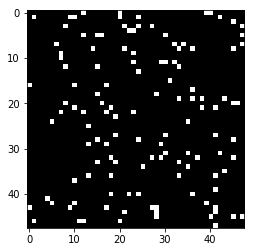

In [1050]:
arr = (np.random.rand(img.shape[0],img.shape[1]) < 0.05).astype(int)       
print(calc_total_log_prob(affinity_tensor, arr, 8,4))
plt.imshow(arr, cmap='gray')

In [2702]:
calc_total_log_prob(
    affinity_tensor, (np.zeros(img.shape)+1).astype(int), kernel_size, stride)

-18732387.029929664

-13276.974854295566


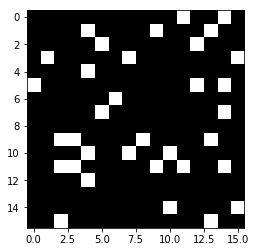

In [767]:
arr = (np.random.rand(16,16) < 0.2).astype(int)
print(calc_total_log_prob(affinity_tensor, arr, 4, 2))
plt.imshow(arr, cmap='gray')

In [156]:
#count_tensor[2,4].flatten() / count_tensor[2,4].flatten().sum()

In [157]:
# total = []
# other = []
# for i in range(img.shape[0]-2):
#     for j in range(img.shape[1]-2):
        
#         total.append([img[i + idx[0], j + idx[1]] for idx in indices])
#         other += [[idx[0], idx[1], ] for idx in indices]

scan across the image, at every location, look at all pairwise combinations of pixels in the window, and add a count to the co-occurence values 

[idx, data] size (3^2 * (width-2)^2, 4)
0, 6, 0, 1
0, 4, 1, 0

or

[pos1, pos2, conv_filter_idx]

-> [pos1, pos2, value1, value2] = count; size (9, 9, 2, 2)

In [158]:
calc_log_prob(affinity_tensor, img, 9, 9, 4)

-171.4119594134845

In [159]:
np.random.rand()

0.4336758440171742

In [ ]:
np.array(
        [kernel_size*floor(a/kernel_size), 
        kernel_size*floor(b/kernel_size)])

In [327]:
# stride=2
# kernel_size=3
# floor((6-kernel_size)/stride)+1

2

In [368]:
# stride=2
# kernel_size=4
# num_convs_h = floor((20-kernel_size)/stride)+1
# print(num_convs_h)
# print(stride*np.random.randint(num_convs_h))

9
12


In [719]:
np.array(filter_idx_to_image_idx[(0,2)])

array([ 2,  3,  4,  5, 18, 19, 20, 21, 34, 35, 36, 37, 50, 51, 52, 53])

In [726]:
np.array([
                img[np.unravel_index(image_idx, img.shape)]
                for image_idx 
                in filter_idx_to_image_idx[(0,2)]])

array([0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [737]:
np.arange(9).reshape((3,3))[np.arange(3),[0,1,2]]

array([0, 4, 8])

In [736]:
np.arange(9).reshape((3,3))[:,[1,2]]

array([[1, 2],
       [4, 5],
       [7, 8]])

In [2299]:
affinity_tensor[
            :, 
            np.arange(81), 
            1, 
            [
                img[np.unravel_index(image_idx, img.shape)]
                for image_idx 
                in filter_idx_to_image_idx[(0,3)]]].shape

(81, 81)

In [1490]:
affinity_tensor.shape

(64, 64, 2, 2)

In [2254]:
37 % 16

5

In [2255]:
37 // 16

2

In [2319]:
np.repeat(np.array([0,2,1]), 3)

array([0, 0, 0, 2, 2, 2, 1, 1, 1])

In [ ]:
image_idx_to_filter_idx

In [2510]:
alt_img.shape

(13, 13, 81)

In [2499]:
def test():
    abs_seq_pos = 34
    filter_info = image_idx_to_filter_idx[abs_seq_pos]
    print(filter_info)
    num_overlapping_filters = filter_info.shape[0]

    relative_positions = filter_info[:,2]
    rep_relative_positions = np.repeat(
        relative_positions, kernel_size**2)
    rep_arange = np.tile(np.arange(kernel_size**2), num_overlapping_filters)
    
    # oh wait nvm going to use this to update the img.. wait shouldnt these be the same?
#     kernel_img_vals = alt_img[
#         (filter_info[:,0]/stride).astype(int),
#         (filter_info[:,1]/stride).astype(int),
#         filter_info[:,2],
#         3
#     ]
    #print(kernel_img_vals)
    kernel_img_vals = alt_img[
        np.repeat((filter_info[:,0]/stride).astype(int), kernel_size**2),
        np.repeat((filter_info[:,1]/stride).astype(int), kernel_size**2),
        rep_arange].astype(int)

    aff = affinity_tensor[
            rep_relative_positions, 
            rep_arange, 
            # index later to get modded config?
            :, 
            kernel_img_vals
    ]

    return aff

test()

[[ 0 27  7]
 [ 0 30  4]
 [ 0 33  1]]


array([[-0.57628266, -2.59856462],
       [-2.08773954, -1.57691424],
       [-0.63690727, -2.15673235],
       [-0.63690727, -2.08773954],
       [-2.23084026, -1.53769354],
       [-0.66865597, -2.02320107],
       [-0.57628266, -2.39789417],
       [ 0.        ,  0.        ],
       [-0.59109775, -2.59856462],
       [-1.08221818, -1.4284943 ],
       [-0.94564269, -1.4635856 ],
       [-1.33005426, -2.08773954],
       [-1.26942967, -1.96257649],
       [-0.96714889, -1.4284943 ],
       [-1.21227127, -2.31088289],
       [-1.03459015, -1.4635856 ],
       [-1.15820407, -2.59856462],
       [-1.21227127, -2.39789417],
       [-1.15820407, -1.53769354],
       [-1.29928262, -1.61773621],
       [-1.13222859, -1.39459276],
       [-1.29928262, -1.39459276],
       [-0.92458928, -2.23084026],
       [-1.08221818, -1.4635856 ],
       [-1.01160064, -2.15673235],
       [-1.29928262, -1.53769354],
       [-1.10691079, -2.15673235],
       [-1.57691424, -1.85135093],
       [-1.6602958 ,

In [2589]:


def mcmc_step(affinity_tensor, img, alt_img, beta, kernel_size, stride, sample_prop=1, 
              max_filters=100, step=None, pix_by_pix=False):
    '''Monte Carlo step using Metropolis algorithm '''
    
    # Get the kernel indices that we're calculating energy for
    h=img.shape[0]
    w=img.shape[1]
    #kernel_idx = np.array(
    #    [kernel_size*floor(a/kernel_size), 
    #    kernel_size*floor(b/kernel_size)])
    num_convs_w = floor((w-kernel_size)/stride)+1
    num_convs_h = floor((h-kernel_size)/stride)+1
    
    image_idx = np.arange(img.shape[0]*img.shape[1]).reshape(img.shape)
    
    
    #for _ in num_mods:
    
    ### Multiply stride by sample from number of filters to get idx of corner
    ##kernel_idx = np.array([
    ##    stride*np.random.randint(num_convs_h),
    ##    stride*np.random.randint(num_convs_w)])
    ##    
    ### Random positions relative to sequence
    
    ##pos1 = np.random.randint(kernel_size**2)
    ##pos2 = np.random.randint(kernel_size**2)
    ### Get relative indices in window
    
    ##idx1 = np.unravel_index(pos1, (kernel_size,kernel_size))
    ##idx2 = np.unravel_index(pos2, (kernel_size,kernel_size))
    ##abs_idx1 = tuple(kernel_idx + idx1)
    ##abs_idx2 = tuple(kernel_idx + idx2)
    ##
    ##abs_seq_pos1 = image_idx[abs_idx1]
    ##abs_seq_pos2 = image_idx[abs_idx2]
    
    
    if pix_by_pix:
        
        # Update pixel by pixel in sequence
        abs_seq_pos = step % (h*w)
        
        # Update pixel by pixel within kernel
#         filter_num = step // kernel_size**2
#         rel_pos = step % kernel_size**2
#         filter_idx = np.unravel_index(filter_num, shape=(num_convs_h, num_convs_w))
#         filter_idx = (filter_idx[0]*stride, filter_idx[1]*stride)
    else:
        abs_seq_pos = np.random.randint(h*w)
    abs_idx = np.unravel_index(abs_seq_pos, (h, w))
    
    
    # Calc current log_prob for sampled window
    ###log_prob, cnt = calc_total_log_prob(
    ###   affinity_tensor, img, kernel_size, stride)
    
    #print(cnt)
    #, res1, res11
#     log_prob = calc_log_prob(
#         affinity_tensor, img, kernel_idx[0], kernel_idx[1], kernel_size)

    # Get current config for pos1 and pos2 and propose new config
    # Accept config with some probability
    
    current_config = img[abs_idx]
    ##
    modded_img = img.copy()
    ###modded_img[abs_idx1] = np.random.randint(2)
    ###modded_img[abs_idx2] = np.random.randint(2)
    ##
    ### just make sure you dont sample old config
    ##sample_config = lambda: [np.random.randint(2), np.random.randint(2)]
    ##proposal_config = sample_config()
    proposal_config = np.random.randint(num_colors)
    while proposal_config == current_config:
        proposal_config = np.random.randint(num_colors)
    ##modded_img[abs_idx1] = proposal_config[0]
    ##modded_img[abs_idx2] = proposal_config[1]
    modded_img[abs_idx] = proposal_config
    
#     print('kernel' , kernel_size,'stride', stride)
#     print('kernel idx:', kernel_idx)
#     print(pos1, pos2, idx1, idx2)
#     print('abs_idx1:', abs_idx1, 'abs_idx2:', abs_idx2)
#     print('current', current_config)
#     print('mod', modded_img[abs_idx1], modded_img[abs_idx2])
    #print('kernel' , kernel_size,'stride', stride)
    #print(abs_seq_pos, abs_idx)
    #print('current', current_config)
    
    delta_likelihood = 0
    
    #abs_seq_pos_list = [abs_seq_pos1, abs_seq_pos2]
    
    # Update the likelihood for both 
    #for i in range(len(abs_seq_pos_list)):
        
    # Check if value is actually changed
    #if current_config[i] != proposal_config[i]:

        #print(i, 'actually changed')

    #abs_seq_pos = abs_seq_pos_list[i]
    
    # 34 -> [(0,2),(2,2) ... ] 
#     filter_corners = np.array(image_idx_to_filter_idx[abs_seq_pos])
#     # subsample filters
#     if len(filter_corners) > max_filters:
#         subsample_filters = np.random.choice(
#             len(filter_corners), size=max_filters, replace=False).astype(int)
#         #print(subsample_filters)
#         filter_corners = filter_corners[subsample_filters]
        
#     #print(filter_corners)
#     #print(img.shape)
#     #print(abs_seq_pos)
#     #print('filter corners', filter_corners)
    
    
    
    
#     for i, j in filter_corners:
#         # (0,2) and 34 -> (2,0)
#         ker_seq_pos = get_seq_pos(i, j, kernel_size, img.shape, abs_seq_pos)
#         #print('ker seq pos:',i,j, abs_seq_pos, '->', ker_seq_pos)

#         # (0,2) -> list of img_seq_idx -> abs_img_idx -> img_vals
#         kernel_img_vals = np.array([
#             img[np.unravel_index(image_idx, img.shape)]
#             for image_idx 
#             in filter_idx_to_image_idx[(i,j)]])

#         #print(kernel_img_vals)
#         subsample_pairs = np.random.choice(
#             kernel_size**2, size=int(sample_prop*kernel_size**2), replace=False).astype(int)
#         #print(subsample_pairs)
#         #print(ker_seq_pos)
#         #print(kernel_img_vals)
#         # should return vector length kernel^2 with likelihoods 
#         updated_local_likelihood = affinity_tensor[
#             ker_seq_pos, 
#             np.arange(kernel_size**2)[subsample_pairs], 
#             proposal_config, 
#             kernel_img_vals[subsample_pairs]]

#         old_local_likelihood = affinity_tensor[
#             ker_seq_pos, 
#             np.arange(kernel_size**2)[subsample_pairs], 
#             current_config, 
#             kernel_img_vals[subsample_pairs]]
#         #print(np.sum(updated_local_likelihood), np.sum(old_local_likelihood))

#         delta_likelihood += (
#             np.sum(updated_local_likelihood) - np.sum(old_local_likelihood))
        
    
    # array of shape (num overlapping filters, 3), rows are (0,2,5)
    filter_info = image_idx_to_filter_idx[abs_seq_pos]
    num_overlapping_filters = filter_info.shape[0]
    
    relative_positions = filter_info[:,2]
    rep_relative_positions = np.repeat(
        relative_positions, kernel_size**2)
    rep_arange = np.tile(np.arange(kernel_size**2), num_overlapping_filters)
    
    #print(filter_info)
    #print(num_overlapping_filters)
    #print(rep_relative_positions)
    #print('\n')
    #print(rep_arange)
    #print('\n')
    #print(np.repeat((filter_info[:,0]/stride).astype(int), kernel_size**2))
    #
    #print()
    kernel_img_vals = alt_img[
        np.repeat((filter_info[:,0]/stride).astype(int), kernel_size**2),
        np.repeat((filter_info[:,1]/stride).astype(int), kernel_size**2),
        rep_arange].astype(int)
    
    aff = affinity_tensor[
            rep_relative_positions, 
            rep_arange, 
            # index later to get modded config?
            :, 
            kernel_img_vals
    ]
    
    #print(aff.shape)
    
    likelihoods = aff.sum(axis=0)
    log_diff = likelihoods[proposal_config] - likelihoods[current_config]
    #print(log_diff)
    
#     for i, j in filter_corners:
#         # (0,2) and 34 -> (2,0)
#         ker_seq_pos = get_seq_pos(i, j, kernel_size, img.shape, abs_seq_pos)
#         #print('ker seq pos:',i,j, abs_seq_pos, '->', ker_seq_pos)

#         # (0,2) -> list of img_seq_idx -> abs_img_idx -> img_vals
#         kernel_img_vals = np.array([
#             img[np.unravel_index(image_idx, img.shape)]
#             for image_idx 
#             in filter_idx_to_image_idx[(i,j)]])

#         #print(kernel_img_vals)
#         subsample_pairs = np.random.choice(
#             kernel_size**2, size=int(sample_prop*kernel_size**2), replace=False).astype(int)
#         #print(subsample_pairs)
#         #print(ker_seq_pos)
#         #print(kernel_img_vals)
#         # should return vector length kernel^2 with likelihoods 
#         updated_local_likelihood = affinity_tensor[
#             ker_seq_pos, 
#             np.arange(kernel_size**2)[subsample_pairs], 
#             proposal_config, 
#             kernel_img_vals[subsample_pairs]]

#         old_local_likelihood = affinity_tensor[
#             ker_seq_pos, 
#             np.arange(kernel_size**2)[subsample_pairs], 
#             current_config, 
#             kernel_img_vals[subsample_pairs]]
#         #print(np.sum(updated_local_likelihood), np.sum(old_local_likelihood))

#         delta_likelihood += (
#             np.sum(updated_local_likelihood) - np.sum(old_local_likelihood))
        
        
                
    # sample img vals and seq position with array later
    
    
    # Proposal log_prob
    ###modded_log_prob, cnt2 = calc_total_log_prob(
    ###   affinity_tensor, modded_img, kernel_size, stride)
    
    #print(cnt2)
    #print('mod')
    #, res2, res22
#     modded_log_prob = calc_log_prob(
#         affinity_tensor, modded_img, kernel_idx[0], kernel_idx[1], kernel_size)

    
    ###log_diff = modded_log_prob - log_prob
    ###log_diff = delta_likelihood
    #print(log_diff)
    
    #print(list(zip(res1, res2)))
    #print([i==j for (i,j) in list(zip(res1, res2))])
    #print(len(res1)-sum([i==j for (i,j) in list(zip(res1, res2))]))
    #print(np.where([i!=j for (i,j) in list(zip(res1, res2))]))
    #print(np.array(res11)[np.where([i!=j for (i,j) in list(zip(res1, res2))])[0]])
    #print(np.array(res22)[np.where([i!=j for (i,j) in list(zip(res1, res2))])[0]])
    






    ##
    #print(log_prob, modded_log_prob)
    #print('log diff', log_diff)
    #print(np.exp(log_diff*beta))

    # If higher likelihood then keep
    if log_diff >= 0:
        #print('accept!')
        #return modded_img, 1, modded_log_prob

        alt_img[
            (filter_info[:,0]/stride).astype(int),
            (filter_info[:,1]/stride).astype(int),
            filter_info[:,2]] = proposal_config
        
        return modded_img, alt_img, 1, log_diff
    
    # if lower likelihood, accept with some prob
    elif np.random.rand() < np.exp(log_diff*beta):
        #print('accept!')
        #return modded_img, 1, modded_log_prob
        
        alt_img[
            (filter_info[:,0]/stride).astype(int),
            (filter_info[:,1]/stride).astype(int),
            filter_info[:,2]] = proposal_config
        
        return modded_img, alt_img, 1, log_diff
    else:
        #print('reject :(')
        #return img, 0, log_prob
        return img, alt_img, 0, 0
    

In [2557]:
# 3
np.random.seed(5)
mcmc_step(affinity_tensor, img, alt_img, beta=5, kernel_size=8, stride=4, sample_prop=0.25, 
          max_filters=10)

KeyError: 2915

In [901]:
img_samp.shape

(16, 16)

In [1528]:
from time import time

In [2907]:
# Run this first!!
#kernel_size=9
#stride=3
#init_samp = np.random.randint(num_colors, size=img.shape)
#gen_size = (48,48)
#assert gen_size[0] % 
init_samp = np.random.randint(num_colors, size=(48,48))
#init_samp = np.random.randint(num_colors, size=(kernel_size, kernel_size))
log_prob_init = calc_total_log_prob(
    affinity_tensor, init_samp, kernel_size=kernel_size, stride=stride)

In [2916]:
#np.random.seed(4)

samps = []
accepts = []
probs = []

img_samp = init_samp
log_prob = log_prob_init


#img_samp = np.zeros(img.shape).astype(int)+1
#img_samp = img[:48, :48]

tot_steps = 30000
upper_beta=0.1
lower_beta=0.003

# Take down temperature over time
betas = np.linspace(lower_beta, upper_beta, tot_steps)

filter_idx_to_image_idx = construct_filters_idx_dict(
    img_samp.shape, kernel_size, stride)

#image_idx_to_filter_idx = invert_dict(filter_idx_to_image_idx)

image_idx_to_filter_idx = invert_filter2img_dict(
    filter_idx_to_image_idx, kernel_size, img_samp.shape)

alt_img_samp = construct_alternate_img_array(
    image_idx_to_filter_idx, img_samp, kernel_size, stride)

#print(log_prob)
start = time()
for step in range(tot_steps):
    img_samp, alt_img_samp, accept, delta_prob = mcmc_step(
        affinity_tensor, 
        img_samp, 
        alt_img_samp,
        beta=betas[step], 
        #beta=lower_beta,
        kernel_size=kernel_size, 
        stride=stride,
        sample_prop=1,
        max_filters=5,
        step=step,
        #pix_by_pix=True
    )
    
    log_prob += delta_prob
    #)
    
    #betas[step]
    samps.append(img_samp)
    accepts.append(accept)
    probs.append(log_prob)
    
    if (step*10) % tot_steps == 0:
        accept_prob = np.array(accepts)[-200:].mean()
        print(f'Step {step} - log_prob = {round(log_prob)}, accept_prob = {accept_prob}' )
end = time()
print(f'Finished in {round(end-start)}s')

Step 0 - log_prob = -1203202.0, accept_prob = 0.0
Step 3000 - log_prob = -1086588.0, accept_prob = 0.405
Step 6000 - log_prob = -1030202.0, accept_prob = 0.235
Step 9000 - log_prob = -1004571.0, accept_prob = 0.17
Step 12000 - log_prob = -995174.0, accept_prob = 0.085
Step 15000 - log_prob = -991911.0, accept_prob = 0.11
Step 18000 - log_prob = -990928.0, accept_prob = 0.07
Step 21000 - log_prob = -989845.0, accept_prob = 0.03
Step 24000 - log_prob = -989680.0, accept_prob = 0.07
Step 27000 - log_prob = -989027.0, accept_prob = 0.03
Finished in 4s


In [2917]:
print(sum(accepts)/len(accepts))

0.15196666666666667


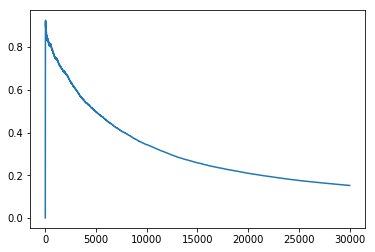

In [2918]:
accept_df = pd.Series(accepts).cumsum().reset_index()
(accept_df[0]/(accept_df['index']+1)).plot()


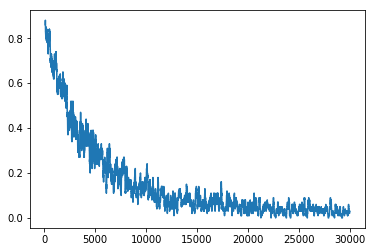

In [2919]:
accept_df = pd.Series(accepts).rolling(100).sum().reset_index()
(accept_df[0]/100).plot()


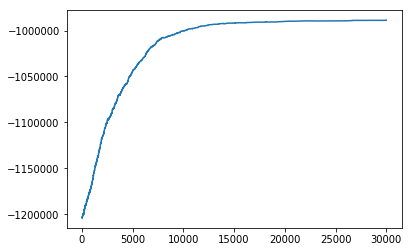

In [2920]:
plt.plot(probs)

In [2921]:
from matplotlib import animation, rc
from IPython.display import HTML

In [2922]:
calc_total_log_prob(affinity_tensor, samps[-1], 4,2)

-93778.07129349507

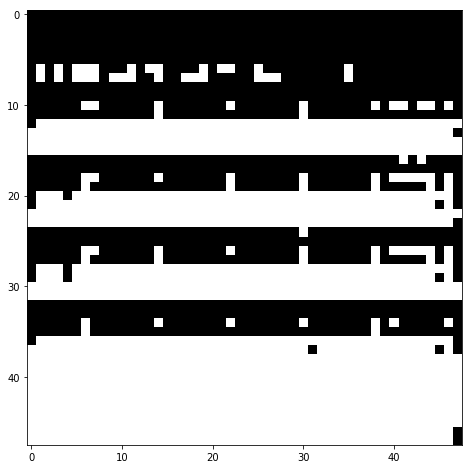

In [2923]:
plt.figure(figsize=(8,8))
plt.imshow(samps[-1],cmap='gray')

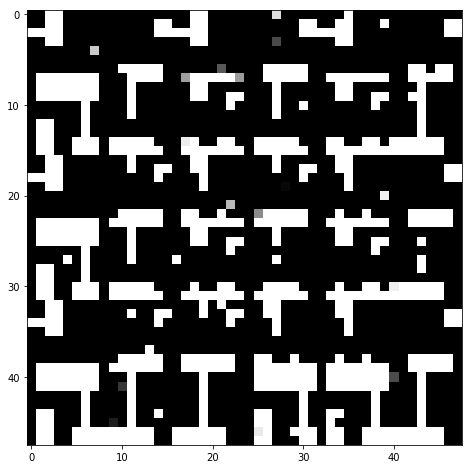

In [2886]:
plt.figure(figsize=(8,8))
plt.imshow(np.array(samps[9000:]).mean(axis=0), cmap='gray')

In [2802]:
import datetime

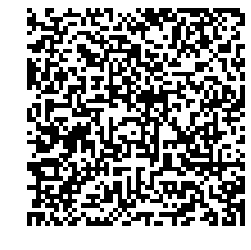

In [2866]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

#im = ax.imshow(samps[0])
ax.axis('off')

num_frames=min(50, len(samps))
frame_idx = np.round(
    np.linspace(0, len(samps)-1, num_frames)).astype(int)

def init():
    im.set_array(samps[0])
    return im

def animate(i):
    #print(i)
    #ax.clear()
    ax.imshow(samps[frame_idx[i]], cmap='gray')
    #im.set_array(samps[i])

anim = animation.FuncAnimation(
    fig, animate, 
    frames=num_frames-1, 
    #init_func=init, 
    interval=75) 

directory = datetime.datetime.now().strftime("%m%d%y_%H%M%S")
anim.save(f'gifs/k{kernel_size}s{stride}ts{tot_steps}lb{lower_beta}ub{upper_beta}_{directory}.gif', writer='imagemagick')

/Users/milesturpin/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:395: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:396: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:403: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/Users/milesturpin/miniconda3/lib/python3.6/site-packages/matplotlib/image.py:408: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(

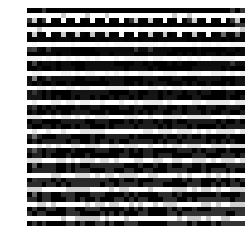

In [2270]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

#im = ax.imshow(samps[0])
ax.axis('off')

samps_arr = np.array(samps)

num_frames=min(50, len(samps))
frame_idx = np.round(
    np.linspace(0, len(samps)-1, num_frames)).astype(int)

def init():
    im.set_array(samps[0])
    return im

def animate(i):
    #print(i)
    #ax.clear()
    ax.imshow(samps_arr[:frame_idx[i]].mean(axis=0), cmap='gray')
    #im.set_array(samps[i])

anim = animation.FuncAnimation(
    fig, animate, 
    frames=num_frames-1, 
    #init_func=init, 
    interval=75) 

directory = datetime.datetime.now().strftime("%m%d%y_%H%M%S")
anim.save(f'gifs/k{kernel_size}s{stride}ts{tot_steps}lb{lower_beta}ub{upper_beta}_{directory}_mean.gif', writer='imagemagick')

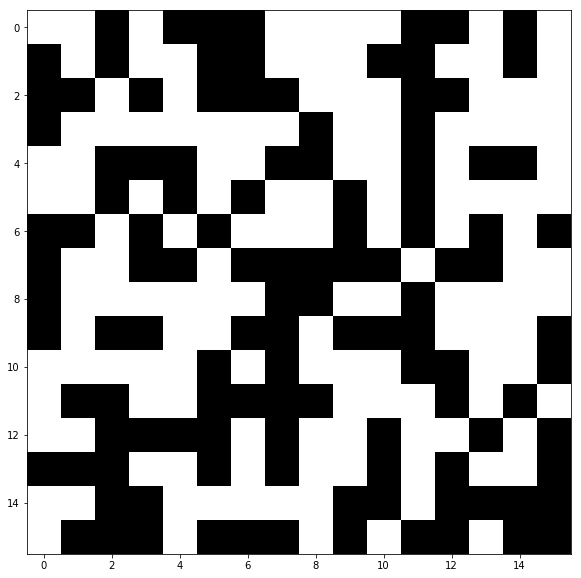

In [75]:
HTML(anim.to_jshtml())

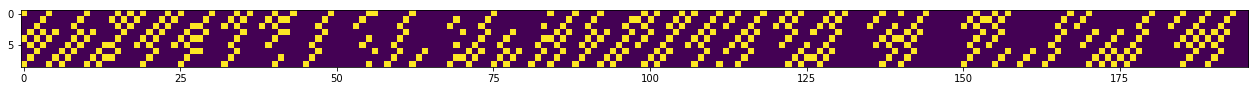

In [138]:
plt.figure(figsize=(22,5))
plt.imshow(np.array(total).T, )

In [146]:
for i in range(len(df.columns)):
    df.loc[:,i] = df.loc[:,i].astype('category')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 9 columns):
0    196 non-null category
1    196 non-null category
2    196 non-null category
3    196 non-null category
4    196 non-null category
5    196 non-null category
6    196 non-null category
7    196 non-null category
8    196 non-null category
dtypes: category(9)
memory usage: 2.6 KB


In [150]:
df = pd.DataFrame(total)

pd.crosstab(df, columns=df.columns)

TypeError: 'int' object is not iterable